In [ ]:
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display as dp
from helper import *
import joblib
from joblib import Parallel, delayed

sns.set_style("darkgrid")

#### 📖 Data Cleaning Table of Contents

[__Clean Data__](#clean-data)
- [1. Null and duplication detection](#1-null-and-duplication-detection)
- [2. Data Type Conversion](#2-type-conversion)
    - [2.1 Format date column](#21-format-date-column)
    - [2.2 Format subject column](#22-format-subject-column)
- [3. Remove rows with extremely short texts](#3-remove-rows-with-extremely-short-texts)
- [4. Text Cleaning](#4-text-cleaning)
- [5. Combine title and text into one column for modeling](#5-combine-title-and-text-into-one-column-for-modeling)

[__Split Datasets__](#split-datasets)


#### Load Data

In [41]:
fdf = pd.read_csv("data/Fake.csv")
tdf = pd.read_csv("data/True.csv")

fdf.shape, tdf.shape

((23481, 4), (21417, 4))

In [42]:
print("fake news")
dp(fdf.head(3))

print("real news")
tdf.head(3)

fake news


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


real news


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


Combine fake news and real news into one dataframe for easy processing

> Label fake news as 1, real news as 0

In [43]:
fdf["label"] = 1
tdf["label"] = 0

org_df = pd.concat([fdf, tdf])
df = pd.concat([fdf, tdf])
df = df.reset_index(drop=True)
df.shape

(44898, 5)

### Clean Data

#### 1. Null and Duplication Detection

- Null detection

In [44]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

- Duplication detection

In [45]:
df.duplicated().sum()

209

> Drop duplications

In [46]:
df = df.drop_duplicates()
assert df.shape == (44689, 5), "Failed to drop duplicates"

#### 2.Data Type Conversion

- convert date column to datetime
- convert subject column to category

##### 2.1 Format date column

In [47]:
def convert_date(
    date_to_convert, date_format_ls=["%B %d, %Y", "%d-%b-%y", "%b %d, %Y", "%Y-%m-%d"]
):

    date_to_convert = date_to_convert.strip()
    for i in date_format_ls:
        try:
            return pd.to_datetime(date_to_convert, format=i)
        except:
            continue
    return np.nan

In [ ]:
converted_date = df["date"].apply(lambda i: convert_date(i))
failed_to_convert_id = converted_date[converted_date.isna()].index.tolist()
print("Dates failed to convert: ")
df.loc[failed_to_convert_id, :]

Dates failed to convert: 


,title,text,subject,date,label
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,1
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,1
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,1
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1


> These rows contain only URLs for most columns, drop them.

In [ ]:
df = df.loc[~df.index.isin(failed_to_convert_id)]

assert df.shape == (
    44679,
    5,
), "Failed to remove rows with date columns filled with URLs in fake news."

converted_and_cleaned_date = df["date"].apply(lambda i: convert_date(i))

df["date"] = converted_and_cleaned_date

##### 2.2 Format subject column

Check subject categories of fake news and real news respectively:

- fake news:

In [50]:
df.query("label == 1").subject.value_counts()

subject
News               9050
politics           6833
left-news          4456
Government News    1568
US_News             783
Middle-east         778
Name: count, dtype: int64

In [51]:
df.query("label == 0").subject.value_counts()

subject
politicsNews    11220
worldnews        9991
Name: count, dtype: int64

> Inconsistent category between fake news and real news.

The category of `subject` column is not consistent between fake news and real news.

- In __real news__, there's only 2 categories: politicsNews and worldnews, and the \
distribution of each are approximately 50%.

- In __fake news__, there's 6 categories, while `it is not easy to catagorize them into` \
`the 2 categories of real news`. 

Using subject as a feature for modeling would lead to `data leakage` due to the \
inconsistency between fake and real news.

> Subject would only be explored in `eda`, but would not be used as a feature in modeling.

#### 3. Remove rows with extremely short texts


Short texts are very likely to be either dirty data we don't want to use for \
modeling or spoilers for fake news.

In [52]:
text_len_series = df["text"].apply(lambda i: len(i.split(" ")))
title_len_series = df["title"].apply(lambda i: len(i.split(" ")))
df["text_len"] = text_len_series
df["title_len"] = title_len_series

stats of text and title length:

In [53]:
dp(text_len_series.describe())
dp(title_len_series.describe())

count    44679.000000
mean       415.525750
std        361.957763
min          1.000000
25%        208.000000
50%        371.000000
75%        525.000000
max       8436.000000
Name: text, dtype: float64

count    44679.000000
mean        12.670583
std          4.171949
min          3.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         45.000000
Name: title, dtype: float64

In [54]:
dp(df.query("text_len < 5"))
print("Texts shorter than 5 words in fake and real news:")
df.query("text_len < 5").label.value_counts()

,title,text,subject,date,label,text_len,title_len
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,2017-05-10,1,2,15
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,2017-04-26,1,2,19
11117,MY FAVORITE EXCUSES…Featuring Hillary Rotten C...,Enjoy:,politics,2017-04-17,1,1,7
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,2017-04-06,1,2,13
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,2017-04-02,1,2,13
...,...,...,...,...,...,...,...
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,2015-04-25,1,2,8
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,2015-04-25,1,2,11
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,2015-04-14,1,2,12
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,2015-04-12,1,2,14


Texts shorter than 5 words in fake and real news:


label
1    762
0      1
Name: count, dtype: int64

> There's some empty text or single word in text column, almost all are fake news.

> Here we'd drop rows with text length shorter than 30.

In [55]:
print("Texts shorter than 30 words in fake and real news:")
df.query("text_len < 30").label.value_counts()

Texts shorter than 30 words in fake and real news:


label
1    1443
0      16
Name: count, dtype: int64

> There's approximately 90 times more texts shorter than 30 words in fake news \
than in real news.

In [56]:
df = df.query("text_len > 30")
assert df.shape[0] == 43194, "Failed to remove texts shorter than 30 words"

#### 4. Text and Title Cleaning

##### 4.1 Text Cleaning

Apart from general text cleaning, we observe some patterns which can cause data \
leakage in respective news groups such as real news starting with `Reuters` or \
some fake news includes `comments from twitter` and many others.

__general cleaning__
- preserve only domain name in URLs
- remove email addresses
- remove special characters and numbers while preserving the important ones
- replace multiple newlines with single newline

__project specific cleaning__
- replace extenal sources links with marker. \
eg: pic.12ab.twitter.com => [TWITTER IMAGE CONTENT]
- remove code injections
- remove broadcast time of some news
- remove non-ascii
- miscellaneous leftover pattern removal
- remove obvious spoliers texts such as:
    - Reuters + location in real news
    - 21st Century Wire in fake news
    - READ MORE .... @21WIRE.TV in fake news
- remove comments in news (ones with obvious timestamp from twitter)
- remove rows which are just advertisement for podcast but contains no news
- remove image source such as: via Getty Image, Featured image is a screenshot
- remove external sources markers. (explained below)

🔴 Note: I decided to removal external content markers because fake news \
contains significantly much more external content links than real news, although \
replace links with markers make the text more tidy, the markers are big spoilers \
for our classificaion task. I would like to model to recognize patterns in words \
rather than relying on these markers.

In [ ]:
# This takes about 30 minutes to run on 4 cores CPU
# parallel processing with joblib
cleaned_text = Parallel(n_jobs=-1)(delayed(process_row)(i) for i in df.text)

In [72]:
df["text"] = cleaned_text
df["text_len"] = df["text"].apply(lambda i: len(i.split(" ")))

##### 4.2 Title Cleaning

Some patterns that might lead to data leakage in title such as: \
`WATCH, REPORT, [VIDEO], #, Factbox, BREAKING:, BREAKING NEWS:, (VIDEO)`, \
`Exclusive, (TWEET)` ...

In [73]:
cleaned_title = df.title.apply(lambda i: news_title_clean(i)).tolist()
df["title"] = cleaned_title
df["title_len"] = df["title"].apply(lambda i: len(i.split(" ")))

Check if there's specific patterns in news subject.

In [74]:
for i in df.subject.unique():
    print(i)
    dp(df.loc[df.subject == i].head(3).title.tolist())

News


['Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing',
 'Drunk Bragging Trump Staffer Started Russian Collusion Investigation',
 'Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’']

politics


['Democrat Senator Warns Mueller Not To Release Findings On Russia Before 2018 Midterms',
 'MSNBC ANCHOR Flabbergasted at What Texas Teachers Do to Protect Their Students',
 'SNOWFLAKES ASKED Communist Party Platform or Democratic Party Platform?']

Government News


['TOP FIVE Food Stamp Fraud Takedowns of 2017…Do You See The Common Thread?',
 'HOUSE INTEL Slaps Subpoenas on McCain Institute Associate Involved in “Trump Dirty Dossier” Sources',
 'PRICELESS! WATCH MSNBC HOST’S Shocked Response When GOP Lawmaker Calls For “Purge” of “Deep State” FBI and DOJ']

left-news


['BARBRA STREISAND Gives Up On Dream Of Impeaching Trump Over Fake Trump-Russian Collusion…Tweets HILARIOUS New Reason Trump Should Be Impeached',
 'SENATOR LINDSEY GRAHAM DROPS BOMBSHELL… FINALLY Confirms The Fake Russian Dossier Was Used To Obtain FISA Warrant To Spy On Trump',
 '“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Neighbors For Hanging “Make America Gay Again Banner” In Front Of House']

US_News


['YEAR IN REVIEW, 2017 Top Ten Conspiracies',
 '‘Classified’ Emails from Hillary Clinton and Huma Abedin found on Anthony Weiner’s Laptop',
 'How Trump is Accelerating the Decline of US Global Influence']

Middle-east


['YEAR IN REVIEW, 2017 Top Ten Conspiracies',
 '‘Classified’ Emails from Hillary Clinton and Huma Abedin found on Anthony Weiner’s Laptop',
 'How Trump is Accelerating the Decline of US Global Influence']

politicsNews


['As U.S. budget fight looms, Republicans flip their fiscal script',
 'U.S. military to accept transgender recruits on Monday, Pentagon',
 "Senior U.S. Republican senator, 'Let Mr. Mueller do his job'"]

worldnews


['Reuters journalists in Myanmar appear in court, remanded for another 14 days',
 'Kuwait says GCC to keep operating despite Qatar crisis',
 'Nigeria says U.S. agrees delayed $593 million fighter plane sale']

News titles in subject `politics, Government News, left-news, Middle-east` \
have the pattern of beginning with a couple of uppercase words. 

> This pattern is more likely to be specific to this dataset, and as it only \
appears in fake news subjects, we would `lowercase all the news titles` to avoid \
data leakage.

In [75]:
df["title"] = df.title.apply(lambda i: i.lower())

__Remove podcasts__

News with podcast content are mainly used for advertisement, and does not contain \
news content are removed for this analysis.

In [78]:
df = df.query("text_len > 30")
# remove podcasts
podcast_idx = df.query('text.str.contains("Episode #")').index
df = df.drop(podcast_idx)
# assert df.shape[0] == 43048, "Failed to remove podcast1"

podcast_idx2 = df.query(
    'text.str.contains("Tune in to the Alternate Current Radio Network")'
).index
df = df.drop(podcast_idx2)
assert df.shape[0] == 42724, "Failed to remove podcast2"

__Text and Title Cleaning__

Here, we focused on addressing dataset specific patterns which can cause data leakage \
due to their imbalanced frequency in fake versus real news. \
Additionally, we removed irrelevant data, such as advertisements for podcasts, \
that do not qualify as news.

Fake news contain significantly more media and social media content than \
real news. To train the model to detect fake news based on semantics rather than \
relying on specific keywords, we removed links and placeholders related to media \
and social media content in fake news.

However, the dataset labeling heavily depends on the source. For instance, a tweet \
from Trump might be labeled as real news when accompanied by a disclaimer from \
`Reuters`, but the same tweet could be labeled as fake news if provided by a different \
source, such as `WIRE21`. In such cases, we retained the source/agency name while \
removing clear labeling patterns.


##### 4.3 Text Duplication Detection

Some rows have duplicated texts, they were not detected by previous duplication \
detection because they have different subject or title. 

As text is going to be the main feature for modeling, drop rows with duplicated \
texts.

- text duplication for fake news

In [82]:
fake_dup = (
    df[df.text.duplicated(keep=False)]
    .sort_values("text_len", ascending=False)
    .query("label == 1")
)
print("fake news duplicates count examples:")

fake_dup.head(4)

fake news duplicates count examples:


,title,text,subject,date,label,text_len,title_len
22303,media tripwire? ping pong pizza conspiracy pro...,Funny how secrets travel. I d start to believe...,US_News,2016-12-28,1,8408,13
23086,media tripwire? ping pong pizza conspiracy pro...,Funny how secrets travel. I d start to believe...,Middle-east,2016-12-28,1,8408,13
22506,"cult crimes, mass shootings & media mind contr...",Shawn Helton mediaThe 1994 cult film Natural B...,US_News,2016-08-13,1,7431,12
23289,"cult crimes, mass shootings & media mind contr...",Shawn Helton mediaThe 1994 cult film Natural B...,Middle-east,2016-08-13,1,7431,12


> Same text, but categorized into different subjects.

- text duplication for real news

In [83]:
real_dup = (
    df[df.text.duplicated(keep=False)]
    .sort_values("text_len", ascending=False)
    .query("label == 0")
)
print("real news duplicates examples: ")

real_dup.head(4)

real news duplicates examples: 


,title,text,subject,date,label,text_len,title_len
35313,"too late, theresa, brexit offer to eu citizens...",Back from Brussels with a hard-fought Brexit d...,worldnews,2017-12-20,0,1211,11
35323,"too late, theresa - brexit offer to eu citizen...",Back from Brussels with a hard-fought Brexit d...,worldnews,2017-12-20,0,1211,12
31962,why the zika virus is causing alarm,Global health officials are racing to better u...,politicsNews,2016-08-11,0,1089,7
31986,why the zika virus is causing alarm,Global health officials are racing to better u...,politicsNews,2016-08-04,0,1089,7


> Same text, slightly different title or different date.

In [84]:
text_dup_idx = df[df.text.duplicated(keep="first")].index
text_dup_fake_idx = df[df.text.duplicated(keep="first") & (df.label == 1)].index
text_dup_real_idx = df[df.text.duplicated(keep="first") & (df.label == 0)].index

print("Text duplicates count:")
print("total: ", len(text_dup_idx))
print("fake news: ", len(text_dup_fake_idx))
print("real news: ", len(text_dup_real_idx))

Text duplicates count:
total:  4985
fake news:  4965
real news:  20


> Almost all text duplicates are fake news.

Drop all rows with duplicated texts (keep the first one):

In [85]:
df = df.drop(text_dup_idx)

assert df.shape[0] == 37739, "Failed to remove text duplicates"

### 5. Split Datasets

#### 5.1 Label Distribution Before and After Cleaning

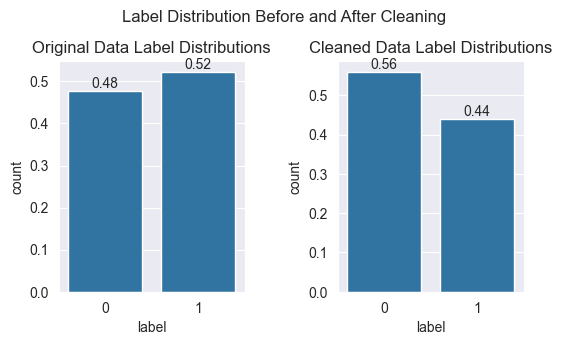

In [86]:
fig_size(6, 3)
plt.subplot(1, 2, 1)
ax = sns.barplot(org_df.label.value_counts() / org_df.label.value_counts().sum())
mark_bar(ax, digit=2)
plt.title("Original Data Label Distributions")


plt.subplot(1, 2, 2)
ax = sns.barplot(df.label.value_counts() / df.label.value_counts().sum())
mark_bar(ax, digit=2)
plt.title("Cleaned Data Label Distributions")
plt.suptitle("Label Distribution Before and After Cleaning", y=1.05)
plt.subplots_adjust(wspace=0.5)
plt.show()

> Initially, the labels were more balanced, but after cleaning, the proportion \
of fake news decreased significantly compared to real news. This was primarily \
due to the removal of duplicate text entries in the fake news category.

#### 5.2 Data Cleaning

Combine title and text into one column for modeling

- sequence = title + " " + text

In [87]:
sequence = df.title + " " + df.text
df["sequence"] = sequence

In [88]:
X = df.loc[:, df.columns.drop("label")]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, shuffle=True, random_state=0
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, shuffle=True, random_state=0
)

X_placeholder, X_demo, y_placeholder, y_demo = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, shuffle=True, random_state=0
)

model_dataset_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "X_demo": X_demo,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "y_demo": y_demo,
}

joblib.dump(model_dataset_dict, "data/model_dataset_dict.pkl")

['data/model_dataset_dict.pkl']

Prepare train dataset for EDA:

In [89]:
eda_df = X_train.copy()
eda_df["label"] = y_train

joblib.dump(eda_df, "data/eda_df_df.pkl")

['data/eda_df_df.pkl']

Ensure the labels are evenly distributed across the datasets:

- 0: real news
- 1: fake news

Label Distribution Count across Datasets:


label,0,1
train,15270,11996
val,2695,2117
test,3170,2491


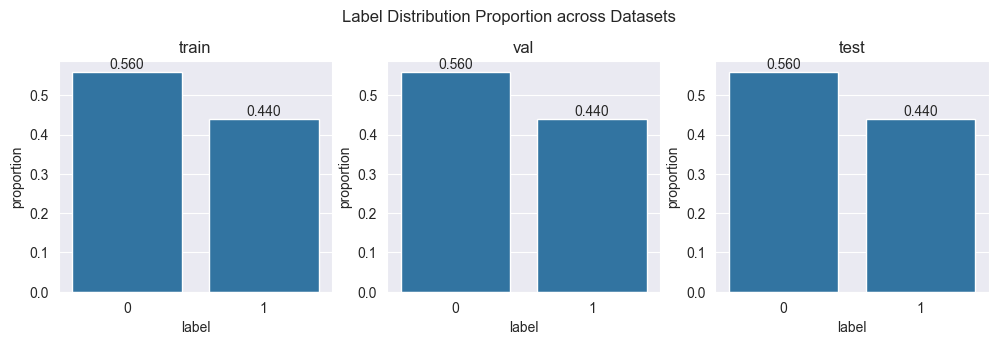

In [16]:
print("Label Distribution Count across Datasets:")
dp(
    pd.DataFrame(
        {
            "train": y_train.value_counts(),
            "val": y_val.value_counts(),
            "test": y_test.value_counts(),
        },
    ).T
)

fig_size(12, 3)
plt.subplot(1, 3, 1)
ax = sns.barplot(y_train.value_counts() / sum(y_train.value_counts()))
mark_bar(ax, digit=3)
plt.ylabel("proportion")
plt.title("train")

ax = plt.subplot(1, 3, 2)
ax = sns.barplot(y_val.value_counts() / sum(y_val.value_counts()))
mark_bar(ax, digit=3)
plt.ylabel("proportion")
plt.title("val")


ax = plt.subplot(1, 3, 3)
ax = sns.barplot(y_test.value_counts() / sum(y_test.value_counts()))
mark_bar(ax, digit=3)
plt.ylabel("proportion")
plt.title("test")

plt.suptitle("Label Distribution Proportion across Datasets", y=1.05)
plt.show()

### 6. Conclusion



💡 This is the end of the notebook, continue to `2_eda.ipynb`